# Определение перспективного тарифа для телеком компании

## 1. Функции

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from urllib.parse import urlencode

In [3]:
LINK_CALLS = "https://yadi.sk/d/-yfOw4HHtN0vAw"
LINK_INTERNET = "https://yadi.sk/d/FOhKnSHxJXPayg"
LINK_MESSAGES = "https://yadi.sk/d/W4Q2ViomDMAjYA"
LINK_TARIFFS = "https://yadi.sk/d/ZANkXDZcnRG_bw"
LINK_USERS = "https://yadi.sk/d/pEYK_9PZgE2C_Q"

In [4]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [5]:
def diff_values(row, per_month, included, rub,  proc=False):
    diff = row[per_month] - row[included]
    if proc:
        diff /= 1024
    fee = int(math.ceil(diff)) * row[rub] if diff > 0 else 0
    return fee

In [6]:
def calculate_income(row):
    """
    Функция для подстчета прибыли из каждой строки
    """
    keys = ['minutes_per_month', 'minutes_included', 'rub_per_minute']
    minutes = diff_values(
        row, *keys)
#         'minutes_per_month', 'minutes_included', 'rub_per_minute')
    messages = diff_values(
        row, *keys)
#         'message_per_month', 'messages_included', 'rub_per_message')
    gb = diff_values(
        row, 'mb_per_month', 'mb_per_month_included', 'rub_per_gb', proc=True) 
    
    result = minutes + messages + gb + row['rub_monthly_fee']
    return result

In [7]:
def get_figure(df_list, labels, kind, title, ax, legend=False):
    """
    Функция построения нескольких графиков
    """
    for i, df in enumerate(df_list):
        df.plot(ax=ax, label=labels[i], kind=kind, title=title, grid=True);

In [8]:
def get_boxplot(df, tariff):
    """
    Функция построения диаграмы размаха для параметров:
        - minutes_per_month
        - message_per_month
        - mb_per_month
    """
    fig, axs = plt.subplots(1, 3, figsize=(15,10))

    for i, point in enumerate(['minutes_per_month', 'message_per_month', 'mb_per_month']):
        get_figure([df[[point]]], [tariff], 'box', point, axs[i])

    fig.tight_layout();

In [9]:
def get_true_range(s, k=1.5):
    """
    Функция для получения границ дтапазона [-k*iqr, +k*iqr]
    """
    iqr = st.iqr(s)
    quantile = s.quantile([.25, .75])
    first = round(quantile[0.25] - k * iqr, 2)
    third = round(quantile[0.75] + k * iqr, 2)
    return (first, third)   

In [10]:
# def drop_values(df):
#     """
#     Функция удаления выбросов
#     """
#     minutes_range = get_true_range(df['minutes_per_month'])
#     messages_range = get_true_range(df['message_per_month'])
#     mb_range = get_true_range(df['mb_per_month'])
    
#     df.drop(df[(df['minutes_per_month'] < minutes_range[0])
#                | (df['minutes_per_month'] > minutes_range[1])
#                | (df['message_per_month'] < messages_range[0])
#                | (df['message_per_month'] > messages_range[1])
#                | (df['mb_per_month'] < mb_range[0])
#                | (df['mb_per_month'] > mb_range[1])].index,
#                 axis=0,
#                 inplace=True
#                )
    
#     return df

In [11]:
# функция удаления выбросов
def drop_values(df):
    """
    Функция удаления выбросов
    """
    minutes_range = get_true_range(df['minutes_per_month'])
    messages_range = get_true_range(df['message_per_month'])
    mb_range = get_true_range(df['mb_per_month'])
    
    df.drop(df[(df['minutes_per_month'] < minutes_range[0])
               | (df['minutes_per_month'] > minutes_range[1])
               | (df['message_per_month'] < messages_range[0])
               | (df['message_per_month'] > messages_range[1])
               | (df['mb_per_month'] < mb_range[0])
               | (df['mb_per_month'] > mb_range[1])].index,
                axis=0,
                inplace=True
               )
    
    return df

In [12]:
def check_null_hypothesis(sample_1, sample_2):
    """
    Функция проверки нулевой гипотезы
    """
    alpha = 0.05
    results = st.ttest_ind(sample_1, sample_2, equal_var=True)
    print('p-value:', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не удалось отвергнуть нулевую гипотезу')

## 2. Загрузка данных

In [13]:
calls_data = pd.read_csv(get_url(LINK_CALLS))
calls_data.head()

Run https://yadi.sk/d/-yfOw4HHtN0vAw


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [14]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [15]:
internet_data = pd.read_csv(get_url(LINK_INTERNET))
internet_data.head()

Run https://yadi.sk/d/FOhKnSHxJXPayg


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [16]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [17]:
messages_data = pd.read_csv(get_url(LINK_MESSAGES))
messages_data.head()

Run https://yadi.sk/d/W4Q2ViomDMAjYA


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [18]:
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [19]:
tariffs_data = pd.read_csv(get_url(LINK_TARIFFS))
tariffs_data.head()

Run https://yadi.sk/d/ZANkXDZcnRG_bw


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [20]:
tariffs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [21]:
users_data = pd.read_csv(get_url(LINK_USERS))
users_data.head()

Run https://yadi.sk/d/pEYK_9PZgE2C_Q


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [22]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [23]:
calls_data[calls_data.duration == 0.0].shape

(39613, 4)

### Вывод

Только в одной таблице обнаружены пропуски - таблица _users_data_, столбец _churn_date_ (дата окончания действия тарифа). В поставленной задаче данные этого столбца учитываться не будут, поэтому обработка пропусков не требуется.

В таблице calls_data множество звонков (39613) с длительностью 0.0 минут. Предположительно, это пропущенные звонки.

Неверно интерпретируется тип столбцов с датой  - потребуется приведение типов (формат _таблица-столбец_ ):
* _users_data_ - _churn_date, reg_date_
* _messages_data_ - _message_date_
* _calls_data_ - _call_date_
* _internet_data_ - _session_date_

В таблице _internet_data_ присутствует столбец без названия _"Unnamed: 0"_.

## 3. Подготовка данных

### 3.1. Преобразование типов данных

В каждой таблице тип данных столбцов с датами - строки. Преобразуем тип в _datetime_.

In [24]:
# В цикле осуществляем преобразование типов столбцов с датами

columns = ['churn_date', 'reg_date', 'message_date', 'call_date', 'session_date']
tables =  [users_data, users_data, messages_data, calls_data, internet_data]
table_names =  ['users_data', 'users_data', 'messages_data', 'calls_data', 'internet_data']

for name, table, column in zip(table_names, tables, columns):
    table[column] = pd.to_datetime(table[column], format="%Y-%m-%d")
    print(table[[column]].dtypes[0])

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


### 3.2. Исправление ошибок

В таблице _internet_data_ присутствует столбец без названия _"Unnamed: 0"_ , который совпадает с индексом. Предположительно, при сохранении в данных в текстовом формате, индекс был сохранен как столбец. Удалим столбец _"Unnamed: 0"_, так как он не понадобится при анализе.

In [25]:
internet_data.drop(['Unnamed: 0'], axis=1, inplace=True)

# проверка
internet_data.sample(5)

,id,mb_used,session_date,user_id
120273,1404_368,663.43,2018-10-21,1404
147155,1492_105,504.57,2018-11-03,1492
19231,1065_376,44.12,2018-09-27,1065
114555,1386_8,84.58,2018-08-24,1386
103632,1350_94,341.27,2018-11-08,1350


В таблицах _users_data, calls_data, messages_data, internet_data_ строковые данные столбцов _city, first_name, last_name, id, tariff_ приведем к одному регистру (нижнему).

In [26]:
str_columns = [
    ('users_data', users_data, 'city'),
    ('users_data', users_data, 'first_name'),
    ('users_data', users_data, 'last_name'),
    ('users_data', users_data, 'tariff'),
    ('calls_data', calls_data, 'id'),
    ('messages_data', messages_data, 'id'),
    ('internet_data', internet_data, 'id')
]

for name, table, column in str_columns:
    table[column] = table[column].str.lower()
    
    # проверка
    print('\nTable {}, column {}:'.format(name, column))
    print(table[[column]].sample(3))


Table users_data, column city:
                 city
59              курск
153         ульяновск
161  набережные челны

Table users_data, column first_name:
    first_name
384   кристина
161    татьяна
150       майя

Table users_data, column last_name:
     last_name
407   пирогова
384  касьянова
148    киреева

Table users_data, column tariff:
    tariff
385  ultra
373  smart
113  smart

Table calls_data, column id:
              id
143599  1363_511
196948  1482_315
196333  1481_140

Table messages_data, column id:
              id
113598  1460_279
104093  1423_426
54440   1243_138

Table internet_data, column id:
             id
65098  1221_211
25737   1089_29
53060  1178_239


### 3.3. Дубликаты

In [27]:
items = [
    ('users_data', users_data),
    ('calls_data', calls_data),
    ('messages_data', messages_data),
    ('internet_data', internet_data),
    ('tariffs_data', tariffs_data)
]

for name, df in items:
    print("\nДубликаты в таблице {}:".format(name))
    print(df.duplicated().value_counts())


Дубликаты в таблице users_data:
False    500
dtype: int64

Дубликаты в таблице calls_data:
False    202607
dtype: int64

Дубликаты в таблице messages_data:
False    123036
dtype: int64

Дубликаты в таблице internet_data:
False    149396
dtype: int64

Дубликаты в таблице tariffs_data:
False    2
dtype: int64


Дублирование данных в таблицах отсутствует.

In [28]:
# посмотрим количество самых минимальных значений
calls_data['duration'].value_counts().sort_index().head(5)

0.00    39613
0.01      101
0.02       84
0.03       80
0.04       85
Name: duration, dtype: int64

In [29]:
# посмотрим количество самых минимальных значений для трафика
internet_data['mb_used'].value_counts().sort_index().head(5)

0.00    19598
0.03        1
0.04        1
0.06        1
0.07        2
Name: mb_used, dtype: int64

В данных присуствуют нулевые значения, а также значения до 1 минуты и до 1 мегабайта. Учитывая специфику работы ПО мобильных операторов:

_подсчет минут осуществляется по принципу N+1_

а также замечание при постановке задачи:

_оператор всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута._

а также замечания ревьюера, выполним округление значений N+1 в бОльшую сторону для длительности вызовов и использованного траффика.

In [30]:
calls_data['duration'] = calls_data['duration'].apply(lambda x: math.ceil(x + 1))
internet_data['mb_used'] = internet_data['mb_used'].apply(lambda x: math.ceil(x + 1))

print(calls_data['duration'].value_counts().sort_index().head(5))
print(internet_data['mb_used'].value_counts().sort_index().head(5))

1    39613
2     8402
3     9194
4    10362
5    10918
Name: duration, dtype: int64
1    19598
2      102
3       98
4       96
5      100
Name: mb_used, dtype: int64


### 3.4. Насыщение данных

Для удобства рассчетов для каждой даты каждой таблицы добавим отдельную колонку с месяцем.

In [31]:
tables = [users_data, calls_data, messages_data, internet_data, tariffs_data]

for tab in tables:
    for col in tab.columns.to_list():
        if 'date' in col:
            tab['month'] = tab[col].dt.month
            
            # для пропущенных значений заполним 0 и переведем в тип int
            if tab['month'].isna().count():
                tab['month'].fillna(0, inplace=True)
                tab['month'] = tab['month'].astype('int')
                
            # проверка
            print("{}\t{}".format('month', tab['month'].dtypes))

month	int64
month	int64
month	int64
month	int64
month	int64


**Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя**

In [32]:
calls_data['minutes_per_month'] = calls_data.groupby(['user_id','month'])['duration'].transform('sum')
calls_data.sort_values(by=['user_id','call_date']).sample(10)

,id,call_date,duration,user_id,month,minutes_per_month
177268,1437_155,2018-10-04,15,1437,10,347
130383,1333_230,2018-11-22,6,1333,11,862
165464,1409_89,2018-09-23,20,1409,9,835
1973,1005_570,2018-05-20,12,1005,5,668
46352,1116_82,2018-08-20,5,1116,8,350
28316,1070_191,2018-12-28,15,1070,12,315
53483,1134_544,2018-03-06,16,1134,3,522
185660,1458_952,2018-03-04,11,1458,3,960
44518,1112_222,2018-10-17,7,1112,10,627
85416,1214_102,2018-08-23,1,1214,8,401


**Количество отправленных сообщений по месяцам для каждого пользователя**

In [33]:
messages_data['message_per_month'] = messages_data.groupby(['user_id', 'month'])['id'].transform('count')
messages_data.sort_values(by=['user_id','message_date']).sample(10)

,id,message_date,user_id,month,message_per_month
25421,1104_613,2018-06-10,1104,6,86
49201,1217_476,2018-12-06,1217,12,78
17434,1076_583,2018-05-23,1076,5,102
60916,1268_231,2018-07-30,1268,7,35
30338,1134_56,2018-08-31,1134,8,66
52376,1231_997,2018-11-07,1231,11,173
40051,1171_195,2018-10-10,1171,10,70
58827,1257_619,2018-12-15,1257,12,135
8584,1033_335,2018-12-13,1033,12,72
78136,1330_162,2018-09-27,1330,9,81


**Объем израсходованного интернет-трафика по месяцам для каждого пользователя**

In [34]:
internet_data['mb_per_month'] = internet_data.groupby(['user_id', 'month'])['mb_used'].transform('sum')
internet_data.sort_values(by=['user_id', 'session_date']).sample(10)

,id,mb_used,session_date,user_id,month,mb_per_month
85742,1291_298,1,2018-10-10,1291,10,11442
81491,1275_274,420,2018-07-03,1275,7,16299
72114,1243_331,559,2018-07-19,1243,7,26466
115286,1389_4,32,2018-12-16,1389,12,16885
94409,1319_109,2,2018-12-17,1319,12,20069
68466,1231_415,449,2018-08-28,1231,8,32137
123461,1415_69,801,2018-11-03,1415,11,26597
94717,1320_135,154,2018-12-09,1320,12,14166
42028,1146_363,350,2018-09-17,1146,9,12900
16503,1057_38,103,2018-08-22,1057,8,14529


**Помесячная выручка с каждого пользователя**

In [35]:
# подготавливаем необходимые данные, чтобы соединить в одну таблицу

# выделение нужных столбцов
data_list = [
    calls_data[['user_id','month','minutes_per_month']],
    messages_data[['user_id', 'month', 'message_per_month']],
    internet_data[['user_id', 'month', 'mb_per_month']]
]

# будем использовать join(), поэтому для корректного объединения будем 
# использовать мульти-индекс 'пользователь-месяц'
data_for_join = [ df.drop_duplicates().set_index(['user_id','month']) for df in data_list ]

In [36]:
# создаем новую таблицу
general_data = data_for_join[0].join(data_for_join[1:]).reset_index()
general_data.sample(5)

,user_id,month,minutes_per_month,message_per_month,mb_per_month
1045,1168,6,1040.0,40.0,32744.0
247,1039,9,684.0,130.0,25001.0
2721,1428,9,472.0,NaN,22412.0
1253,1198,10,403.0,4.0,17874.0
112,1015,8,448.0,68.0,27524.0


In [37]:
# изменим имя столбца для возможности дальнейшего объединения
tariffs_data.rename(columns={'tariff_name':'tariff'}, inplace=True)

In [38]:
# сразу объединяем с данными о пользователе и тарифном плане
# здесь меньше данных, удобнее использовать merge()
general_data = (
    general_data
    .merge(users_data[['user_id','tariff','city']],on='user_id')
    .merge(tariffs_data, on='tariff')
)

In [39]:
general_data.sample(5)

,user_id,month,minutes_per_month,message_per_month,mb_per_month,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
1874,1197,10,607.0,28.0,24851.0,smart,красноярск,50,15360,500,550,200,3,3
2937,1447,12,842.0,66.0,23915.0,smart,москва,50,15360,500,550,200,3,3
2021,1228,9,492.0,NaN,11517.0,smart,нижний новгород,50,15360,500,550,200,3,3
274,1167,11,671.0,148.0,19988.0,ultra,кемерово,1000,30720,3000,1950,150,1,1
2201,1274,12,474.0,91.0,16557.0,smart,волгоград,50,15360,500,550,200,3,3


In [40]:
# проверка - нет ли пропущенных значений
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3174 non-null   int64  
 1   month                  3174 non-null   int64  
 2   minutes_per_month      3174 non-null   float64
 3   message_per_month      2678 non-null   float64
 4   mb_per_month           3163 non-null   float64
 5   tariff                 3174 non-null   object 
 6   city                   3174 non-null   object 
 7   messages_included      3174 non-null   int64  
 8   mb_per_month_included  3174 non-null   int64  
 9   minutes_included       3174 non-null   int64  
 10  rub_monthly_fee        3174 non-null   int64  
 11  rub_per_gb             3174 non-null   int64  
 12  rub_per_message        3174 non-null   int64  
 13  rub_per_minute         3174 non-null   int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 372.0+ 

Полученная таблица показывает, что одна часть пользователей не пользовалась мобильным интернетом в течение некоторых месяцев, другая - не отправляла сообщения. Заполним пропуски 0.

In [41]:
general_data[['message_per_month', 'mb_per_month']] = general_data[['message_per_month', 'mb_per_month']].fillna(0)
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3174 non-null   int64  
 1   month                  3174 non-null   int64  
 2   minutes_per_month      3174 non-null   float64
 3   message_per_month      3174 non-null   float64
 4   mb_per_month           3174 non-null   float64
 5   tariff                 3174 non-null   object 
 6   city                   3174 non-null   object 
 7   messages_included      3174 non-null   int64  
 8   mb_per_month_included  3174 non-null   int64  
 9   minutes_included       3174 non-null   int64  
 10  rub_monthly_fee        3174 non-null   int64  
 11  rub_per_gb             3174 non-null   int64  
 12  rub_per_message        3174 non-null   int64  
 13  rub_per_minute         3174 non-null   int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 372.0+ 

In [42]:
general_data['income'] = general_data.apply(calculate_income, axis=1)
general_data.sample(5)

,user_id,month,minutes_per_month,message_per_month,mb_per_month,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
3036,1472,12,703.0,64.0,19053.0,smart,ярославль,50,15360,500,550,200,3,3,2568
1418,1107,8,306.0,0.0,23438.0,smart,орёл,50,15360,500,550,200,3,3,2150
2256,1285,5,352.0,102.0,6082.0,smart,краснодар,50,15360,500,550,200,3,3,550
2897,1435,7,275.0,0.0,20382.0,smart,москва,50,15360,500,550,200,3,3,1550
2313,1299,6,447.0,46.0,20822.0,smart,уфа,50,15360,500,550,200,3,3,1750


Из  таблицы _general_data_ выделим 2 отдельные таблицы с разными тарифами.

In [43]:
# отдельно сохраним данные по тарифу ultra
ultra_data = general_data[general_data.tariff == 'ultra']
ultra_data.head()

,user_id,month,minutes_per_month,message_per_month,mb_per_month,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
0,1000,7,387.0,75.0,14045.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950
1,1000,8,460.0,81.0,14099.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950
2,1000,6,215.0,60.0,23306.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950
3,1000,9,524.0,57.0,14608.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950
4,1000,12,379.0,70.0,9848.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,1950


In [44]:
# отдельно сохраним данные по тарифу smart
smart_data = general_data[general_data.tariff == 'smart']
smart_data.head()

,user_id,month,minutes_per_month,message_per_month,mb_per_month,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
951,1001,11,489.0,0.0,18507.0,smart,москва,50,15360,500,550,200,3,3,1350
952,1001,12,477.0,0.0,14094.0,smart,москва,50,15360,500,550,200,3,3,550
953,1002,9,242.0,4.0,16768.0,smart,стерлитамак,50,15360,500,550,200,3,3,950
954,1002,8,331.0,13.0,20407.0,smart,стерлитамак,50,15360,500,550,200,3,3,1550
955,1002,12,269.0,12.0,18199.0,smart,стерлитамак,50,15360,500,550,200,3,3,1150


### 3.5. Выбросы

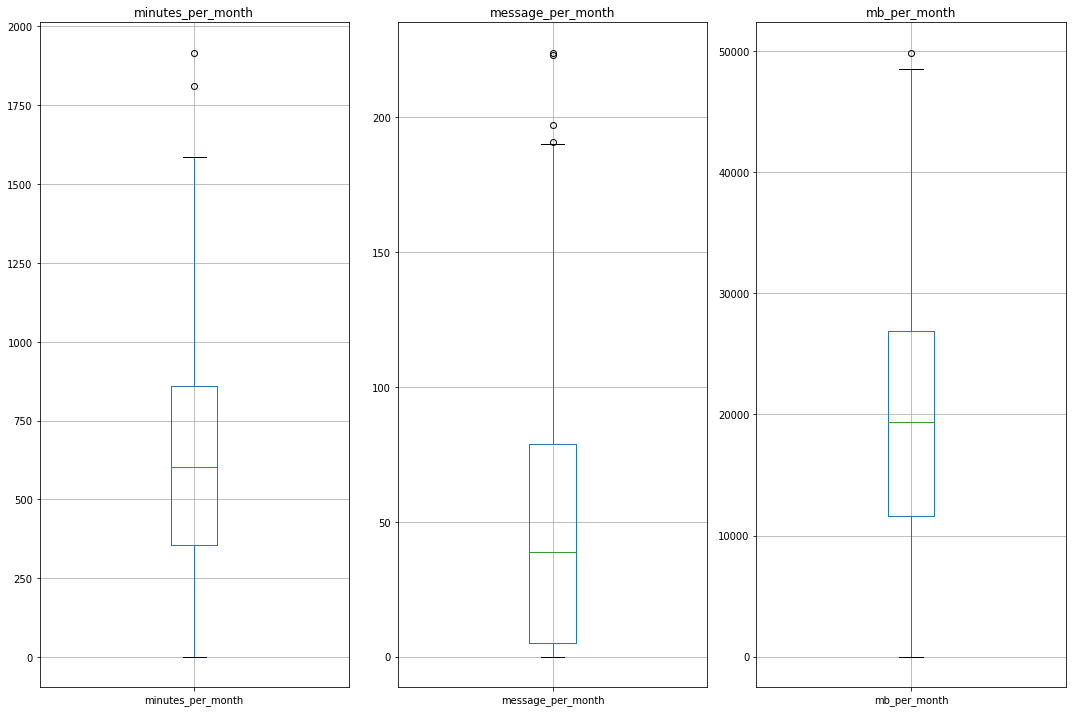

In [45]:
# посмотрим на гистограмму размаха расхода минут, сообщений и трафика в 
# месяц для тарифа ultra
get_boxplot(ultra_data, 'ultra')

В данных количества израсходованных минут, сообщений и трафика присутствуют выбросы. Посмотрим на их количество.

In [46]:
before_ultra = ultra_data.shape

In [47]:
get_true_range(ultra_data.minutes_per_month)[1]

1618.25

Удалим выбросы из данных.

In [48]:
# удаление выбросов
ultra_data = drop_values(ultra_data)

In [49]:
# посмотрим, сколько данных выбросили
print(before_ultra)
print(ultra_data.shape)

(951, 15)
(944, 15)


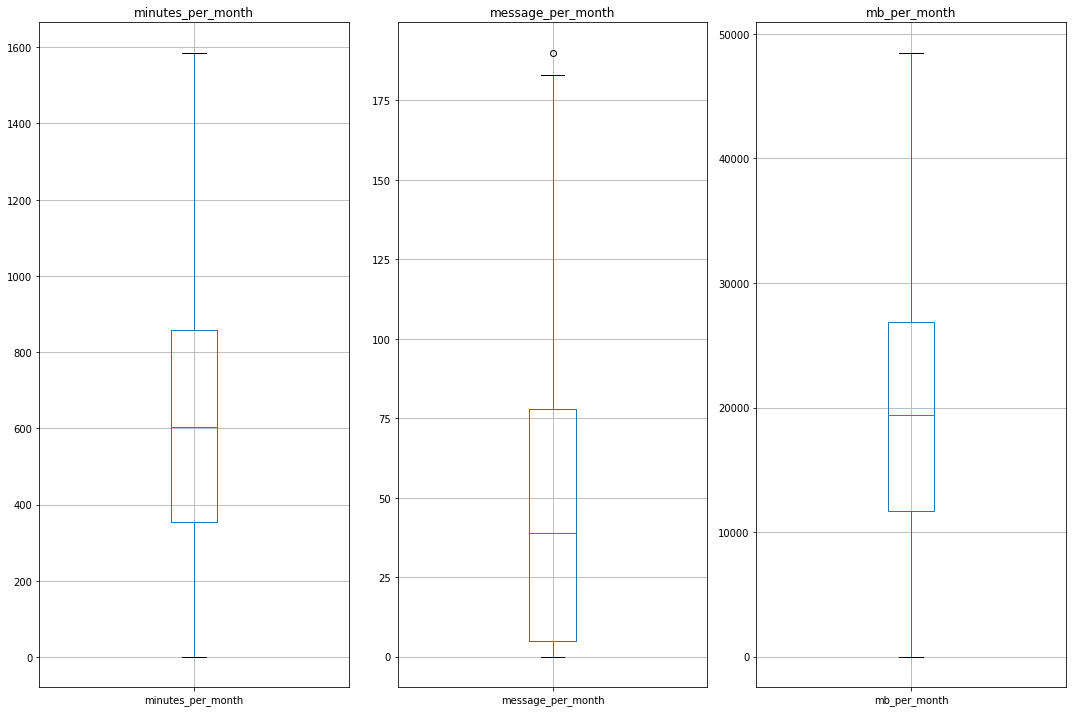

In [50]:
# посмотрим на гистограмму размаха расхода минут, сообщений и трафика в месяц 
# для тарифа ultra после удаления выбросов
get_boxplot(ultra_data, 'ultra')

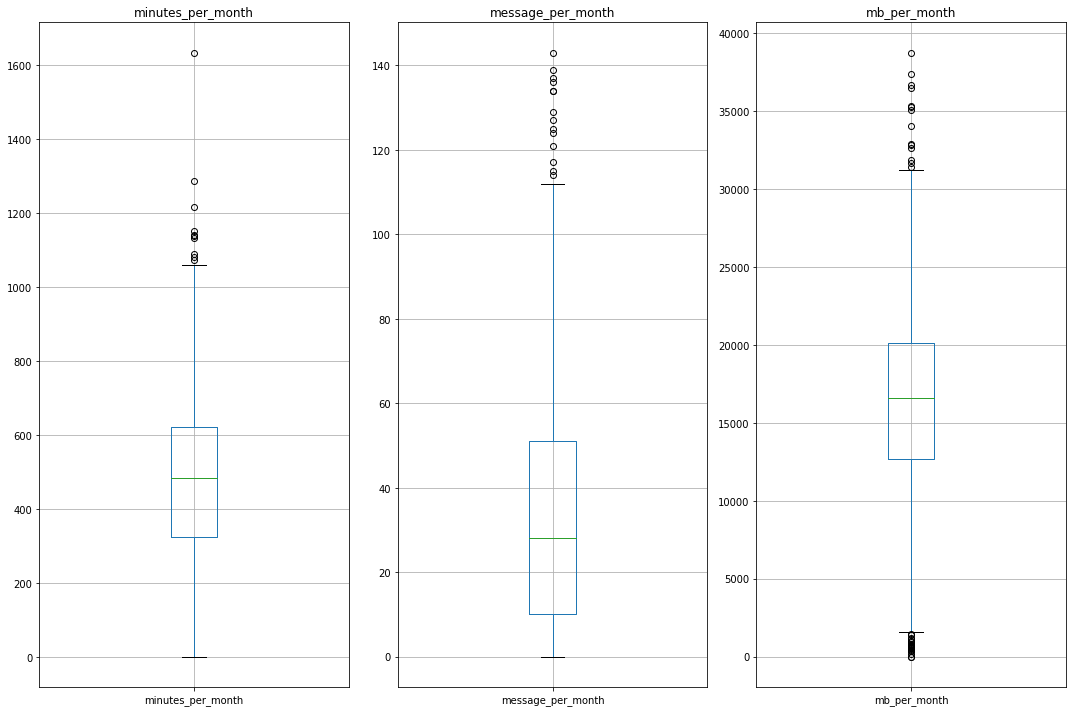

In [51]:
# посмотрим на гистограмму размаха расхода минут, сообщений и трафика в 
# месяц для тарифа smart
get_boxplot(smart_data, 'smart')

Для тарифа _smart_ намного больше выбросов.

In [52]:
# размер данных до обработки выбросов
before_smart = smart_data.shape

In [53]:
# удаление выбросов
smart_data = drop_values(smart_data)

In [54]:
print(before_smart)
print(smart_data.shape)

(2223, 15)
(2164, 15)


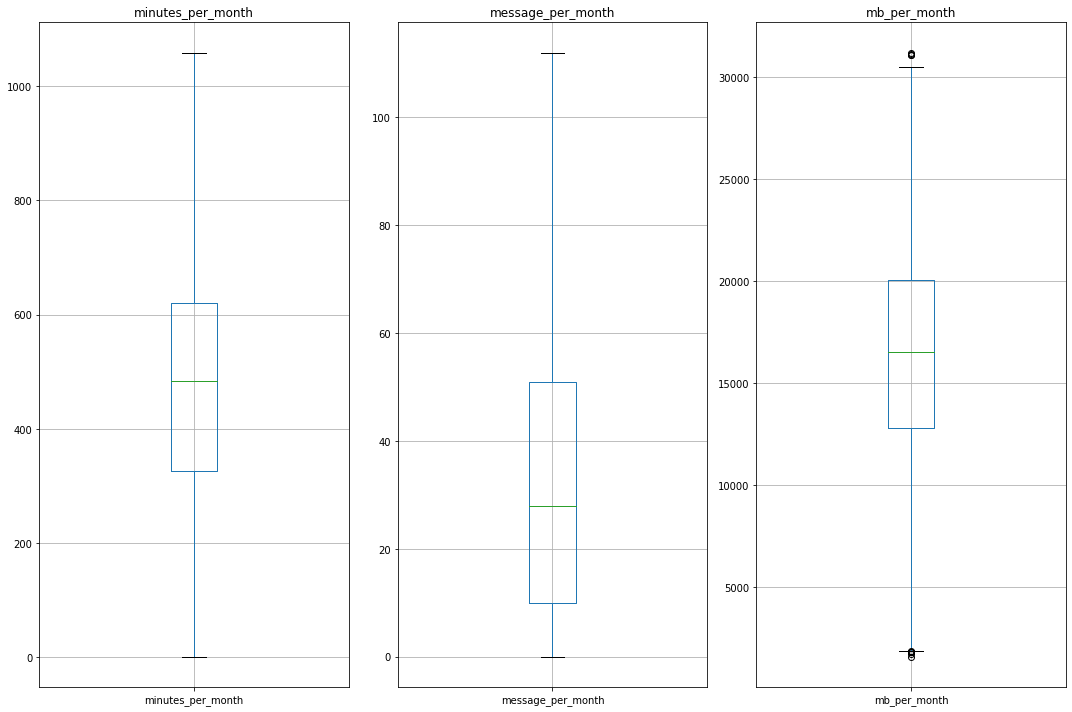

In [55]:
# посмотрим на гистограмму размаха расхода минут, сообщений и трафика в месяц 
# для тарифа smart после удаления выбросов
get_boxplot(smart_data, 'smart')

### Вывод

* Изменены типы данных
* Удалены лишние столбцы
* Проведен поиск пропусков - обнаруженные пропуски нет смсла заменять
* Проведен поиск дубликатов - отсутствуют
* Строковые данные приведены к согласованному виду
* Выполнено добавление данных по месяцам для каждого пользователя:
    * расход минут
    * расход сообщений
    * расход трафика
    * общий доход
* Данные разделены на 2 отдельные талицы для каждого тарифа
* Для каждого тарифа удалены выбросы для количества израсходованных минут, сообщений и трафика.

## 4. Анализ

Для оценки расхода минут, сообщений и траффика посмотрим на график _среднего_ по месяцам

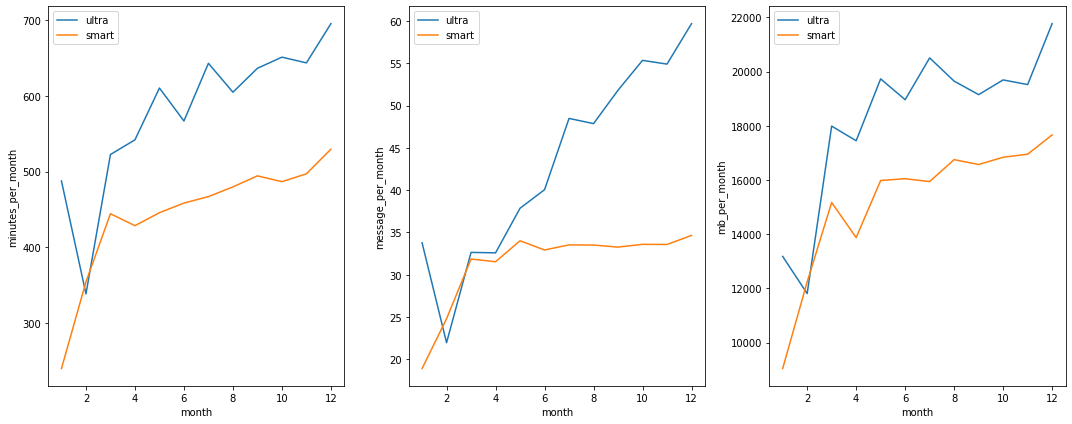

In [56]:
# посторим графики для каждого тарифа по месяцам для демонстрации расхода 
# минут, сообщений и трафика

fig, axs = plt.subplots(1, 3, figsize=(15,6))

for ax, point in zip(axs, ['minutes_per_month', 'message_per_month', 'mb_per_month']):
    udata = ultra_data.groupby('month')[[point]].mean()
    sdata = smart_data.groupby('month')[[point]].mean()
    
    for df, lb in zip([udata, sdata], ['ultra', 'smart']):
        ax.plot(df, label=lb)
        ax.set_ylabel(point)
        ax.set_xlabel('month')
        ax.legend(loc="upper left")
        
fig.tight_layout()

Из графиков видно:
* для каждого тарифа в течение года расход минут, сообщений и трафика возрастает
* для тарифа _ultra_ расход услуг возрастает стремительнее, сем для _smart_

Посмотрим, сколько минут разговора, сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [57]:
# описательная статистика тарифа ultra
ultra_data[['minutes_per_month', 'message_per_month', 'mb_per_month']].describe()

,minutes_per_month,message_per_month,mb_per_month
count,944.000000,944.000000,944.000000
mean,618.003178,48.322034,19453.939619
std,343.737136,45.813839,10070.955049
min,1.000000,0.000000,0.000000
25%,354.750000,5.000000,11674.750000
50%,603.000000,39.000000,19367.000000
75%,859.250000,78.000000,26861.500000
max,1586.000000,190.000000,48488.000000


In [58]:
# описательная статистика тарифа smart
smart_data[['minutes_per_month', 'message_per_month', 'mb_per_month']].describe()

,minutes_per_month,message_per_month,mb_per_month
count,2164.000000,2164.000000,2164.00000
mean,476.688540,33.064233,16300.75647
std,204.949464,27.252353,5534.04260
min,1.000000,0.000000,1605.00000
25%,327.000000,10.000000,12802.50000
50%,484.000000,28.000000,16552.50000
75%,620.000000,51.000000,20069.00000
max,1059.000000,112.000000,31209.00000


Из описания данных следует:
* для _ultra_ абоненты используют:
    * от 1 до 1586 минут, в среднем - 618 мин.
    * от 0 до 190 сообщений, в среднем - 48 сообщений
    * от 0 до 48488 МБ, в среднем - 19454 МБ трафика
    
    
* для _smart_ пользователи расходуют:
    * от 1 до 1059 минуты, в среднем - 477 мин.
    * от 0 до 112 сообщений, в среднем - 33 сообщений
    * от 0 до 31209 МБ, в среднем - 16300 МБ трафика

Посчитаем среднее количество, дисперсию и стандартное отклонение для каждой услуги каждого тарифа.

In [59]:
ultra_data[['minutes_per_month', 'message_per_month', 'mb_per_month']].apply(
    [np.mean, np.var, np.std])

,minutes_per_month,message_per_month,mb_per_month
mean,618.003178,48.322034,1.945394e+04
var,118155.218442,2098.907849,1.014241e+08
std,343.737136,45.813839,1.007096e+04


In [60]:
smart_data[['minutes_per_month', 'message_per_month', 'mb_per_month']].apply(
    [np.mean, np.var, np.std])

,minutes_per_month,message_per_month,mb_per_month
mean,476.688540,33.064233,1.630076e+04
var,42004.282975,742.690740,3.062563e+07
std,204.949464,27.252353,5.534043e+03


 Посмотрим гистограммы для каждой услуги каждого тарифа.

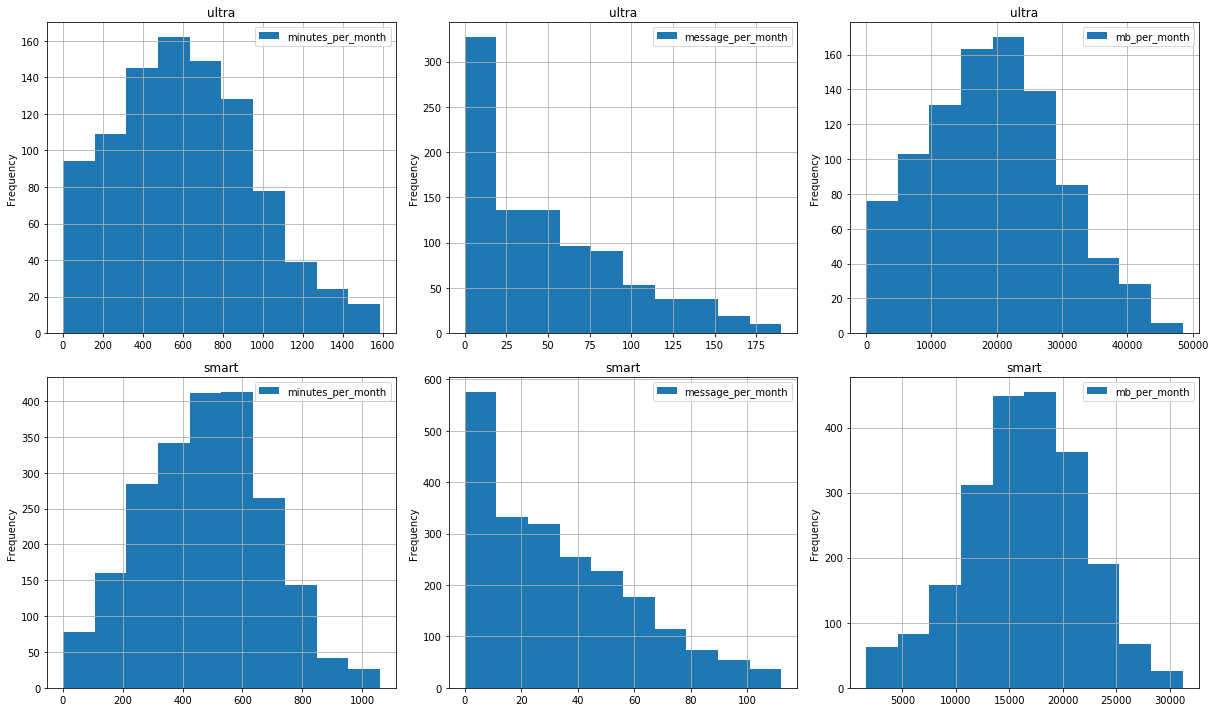

In [61]:
# посмотрим на гистограмму распределения расхода минут, сообщений и трафика 
# в месяц для двух тарифов

fig, axs = plt.subplots(2, 3, figsize=(17,10))
i = 0

for tariff, df in zip(['ultra', 'smart'], [ultra_data, smart_data]):
    for j, point in enumerate(['minutes_per_month', 'message_per_month', 'mb_per_month']):
        data = df[[point]]
        get_figure([data], [tariff], 'hist', tariff, axs[i,j], legend=True)
    i += 1

fig.tight_layout()

### Вывод

Видно, что поведение при использовании каждой услуги поведение пользователей примерно одинаковое:
* использование пакета минут стремится к нормальному распределению, однако медиана у тарифа _ultra_ больше
* использование интренет-трафика также стремится к нормальному распределению аналогично использованию минут
* расход сообщений чаще всего приходится на количество от 0 до 15 сообщений - наименее активно используемая услуга

## 5. Проверка гипотез

### 5.1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформулируем _нулевую_ гипотезу: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равна". Тест будет осуществляться как сравнение двух средних, так как сравниваем две выборки по средним.

Сформулируем _альтернативную_ гипотезу: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается". 

In [62]:
ultra_data[['income']].apply([np.mean, np.var, np.std])

,income
mean,2067.584746
var,136334.139152
std,369.234531


In [63]:
smart_data[['income']].apply([np.mean, np.var, np.std])

,income
mean,1.572623e+03
var,1.015233e+06
std,1.007588e+03


Посмотрим на распределение выручки для тарифов "Ультра" и "Смарт".

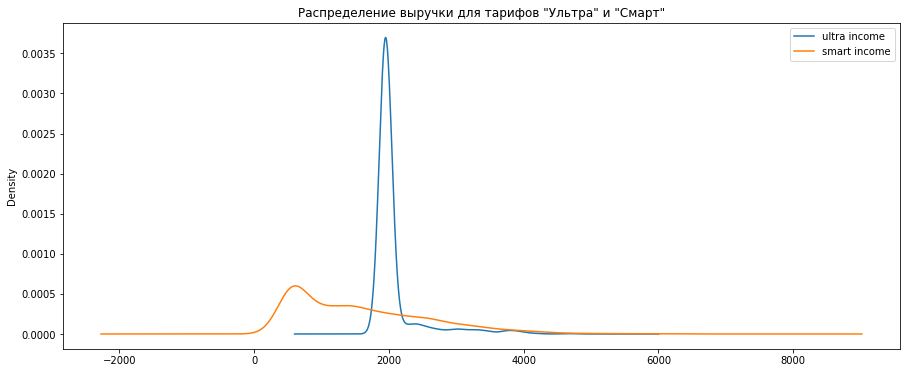

In [64]:
ax = ultra_data.income.plot.kde(figsize=(15,6));
smart_data.income.plot.kde(ax=ax);
ax.legend(['ultra income', 'smart income'])
ax.set_title('Распределение выручки для тарифов "Ультра" и "Смарт"');

Для обоих тарифов распределение нормальное, данные количественные и значения друг от друга не зависят, нулевая гипотеза - двухсторонняя, поэтому можем применить t-критерий Стьюдента.

In [65]:
# проверим нулевую гипотезу
check_null_hypothesis(ultra_data.income, smart_data.income)

p-value: 3.7488761397524414e-47
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергли,соответственно имеет место альтернативная - "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается" ( по значениям средних видно, что у "Ультра" больше).

### 5.2.  Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем _нулевую_ гипотезу: "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов". Тест будет осуществляться как сравнение двух средних, так как сравниваем две выборки по средним.

Сформулируем _альтернативную_ гипотезу: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов". 

In [66]:
# из 2 таблиц выбираем данные о доходе и городе, соединяем в одну талицу
ultra_income = ultra_data[['city', 'income']]
smart_income = smart_data[['city', 'income']]
city_income = pd.concat([ultra_income, smart_income])
city_income.sample(5)

,city,income
1136,москва,950
2864,санкт-петербург,1350
2612,махачкала,2104
1676,новокузнецк,750
138,иркутск,1950


In [67]:
# разделим данные на москву и не москву
moscow_income = city_income[city_income.city == 'москва']
other_income = city_income[city_income.city != 'москва']

In [68]:
# проверка нулевой гипотезы
check_null_hypothesis(moscow_income.income, other_income.income)

p-value: 0.923272886397166
Не удалось отвергнуть нулевую гипотезу


In [69]:
# посмотрим на  средние
print(moscow_income.income.mean(), other_income.income.mean())

1726.102479338843 1722.1989612465043


**Вывод**

Согласно посавленной задаче сфомулированы 2 нулевые гипотезы:
1. "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны" - гипотеза отвергнута. Соответственно, можно предположить, что верна альтернативная гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается" - больше или меньше.


2. "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов" - не получилось отвергнуть гипотезу. Соответственно, средний доход по Москве и другим города примерно одинаковый - 1482 и  1440 (при стандартное отклонение 718).

## 6. Общий вывод

При подготовке данных выполнено:
* преобразование типов данных;
* удаление лишних столбцов;
* поиск пропусков (обнаруженные пропуски нет смсла заменять);
* поиск дубликатов;
* приведение строковых данных к согласованному виду;
* добавление расхода услуг по месяцам для каждого пользователя;
* разделение данных на 2 отдельные талицы для каждого тарифа;
* удалены выбросы.

Из анализа выяснено:
* использование пакета минут, интренет-трафика стремится к нормальному распределению;
* расход сообщений чаще всего приходится на количество от 0 до 15 сообщений - наименее активно используемая услуга.

Согласно поставленной задаче сформулированы и проверены 2 нулевые гипотезы:
1. "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны" - гипотеза отвергнута.
2. "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов" - не удалось отвергнуть гипотезу.

Согласно результатам, средняя выручка ultra,больше средней выручки smart. Поэтому предолагаем, что тариф _ultra_ выгоднее с точки зрения прибыли.